In [11]:
import os
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import defaultdict
import scienceplots
plt.style.use('science')

save_root_dir = 'archive/tennis_abstract_dfs_good_Elos'
backup_root_dir = 'archive/tennis_abstract_dfs_Elo_backup'
big_df_name = 'big_df.pkl'
df_root_dir = 'tennis_abstract_dfs'
surfs = ['Clay', 'Grass', 'Hard']
# poly3d_coeefs = [-3.62592888,  5.42864825, -0.86041857,  0.02900003]
poly3d_coeefs = [-3.51591704,  5.26301386, -0.79325641,  0.02302555]
swr_baseline = 63.5
rwr_baseline = 36.5


In [12]:
def restore_df():
    backup_path = f'{backup_root_dir}/{big_df_name}'
    file_path = f'{big_df_name}'
    og = pd.read_pickle(backup_path)
    pd.to_pickle(og, file_path)


def save_df():
    save_path = f'{save_root_dir}/{big_df_name}'
    file_path = f'{big_df_name}'
    og = pd.read_pickle(file_path)
    pd.to_pickle(og, save_path)

def backup_df():
    save_path = f'{backup_root_dir}/{big_df_name}'
    file_path = f'{big_df_name}'
    og = pd.read_pickle(file_path)
    pd.to_pickle(og, save_path)

# save_df()
# backup_df()
# restore_df()

big_df = pd.read_pickle(big_df_name)

all_names = set(big_df['formatted_player']).union(big_df['formatted_opp'])
all_names = list(all_names)
len(all_names)


195

In [13]:
def set_matchnums():
    for player in tqdm(all_names):
        p_df = big_df[(big_df['formatted_player'] == player) | (big_df['formatted_opp'] == player)].reset_index()
        home_away = p_df['formatted_player'] == player
        big_df.loc[p_df.loc[home_away, 'index'], 'p_matchnum'] = p_df[home_away].index + 1
        big_df.loc[p_df.loc[~home_away, 'index'], 'o_matchnum'] = p_df[~home_away].index + 1
    pd.to_pickle(big_df, big_df_name)

# set_matchnums()
# backup_df()
# save_df()

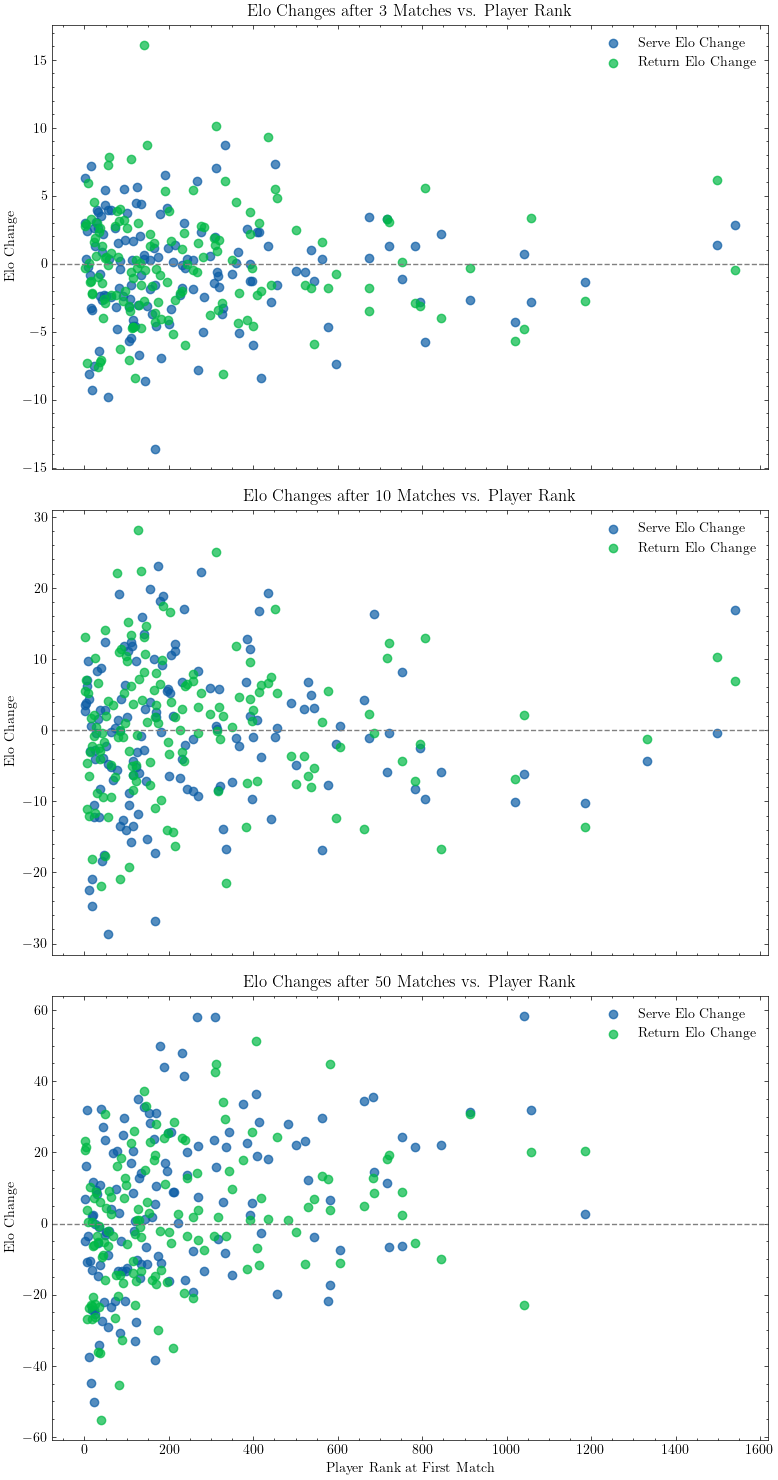

In [16]:
match_nums = [3, 10, 50]
fig, axs = plt.subplots(len(match_nums), 1, figsize=(8, 5 * len(match_nums)), sharex=True)

for idx, num_matches in enumerate(match_nums):
    elo_changes = defaultdict(list)
    for player in all_names:
        first_match = big_df[((big_df['formatted_player'] == player) & (big_df['p_matchnum'] == 1)) | ((big_df['formatted_opp'] == player) & (big_df['o_matchnum'] == 1))]
        nth_match = big_df[((big_df['formatted_player'] == player) & (big_df['p_matchnum'] == num_matches)) | ((big_df['formatted_opp'] == player) & (big_df['o_matchnum'] == num_matches))]
        if first_match.shape[0] != 1 or nth_match.shape[0] != 1:
            continue
        first_match = first_match.iloc[0]
        nth_match = nth_match.iloc[0]

        home_away = first_match['formatted_player'] == player
        elo_prefix = 'o' if not home_away else ''
        first_serve_elo = first_match[f'{elo_prefix}R_o_s']
        first_return_elo = first_match[f'{elo_prefix}R_o_r']

        home_away = nth_match['formatted_player'] == player
        elo_prefix = 'o' if not home_away else ''
        nth_serve_elo = nth_match[f'{elo_prefix}R_o_s']
        nth_return_elo = nth_match[f'{elo_prefix}R_o_r']

        try:
            key = int(first_match[f'{elo_prefix}rank'])
        except (ValueError, TypeError):
            key = 500

        elo_changes[key] = [nth_serve_elo - first_serve_elo, nth_return_elo - first_return_elo]

    elo_diffs = np.array(list(elo_changes.values()))
    elo_ranks = np.array(list(elo_changes.keys()))
    ax = axs[idx] if len(match_nums) > 1 else axs
    ax.scatter(elo_ranks, elo_diffs[:, 0], alpha=0.7, label='Serve Elo Change')
    ax.scatter(elo_ranks, elo_diffs[:, 1], alpha=0.7, label='Return Elo Change')
    ax.set_ylabel('Elo Change')
    ax.set_title(f'Elo Changes after {num_matches} Matches vs. Player Rank')
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.legend()

axs[-1].set_xlabel('Player Rank at First Match')
plt.tight_layout()
plt.show()



In [15]:
# Compute mean serve and return Elo change after 50 matches for different rank bins using elo_changes from above
elo_diffs = np.array(list(elo_changes.values()))
elo_ranks = np.array(list(elo_changes.keys()))

bins = [(0, 10), (10, 20), (20, 30), (30, 40), (40, 50), (50, 100), (100, np.inf)]
labels = ["0-10", "10-20", "20-30", "30-40", "40-50", "50-100", "100+"]

serve_changes = []
return_changes = []

for (low, high), label in zip(bins, labels):
    mask = (elo_ranks >= low) & (elo_ranks < high)
    if np.any(mask):
        mean_serve_change = np.mean(elo_diffs[mask, 0])
        mean_return_change = np.mean(elo_diffs[mask, 1])
        serve_changes.append((label, mean_serve_change))
        return_changes.append((label, mean_return_change))
    else:
        serve_changes.append((label, None))
        return_changes.append((label, None))

print("Mean serve Elo change after 50 matches by rank bin:")
for label, val in serve_changes:
    if val is not None:
        print(f"  {label}: {val:.2f}")
    else:
        print(f"  {label}: No players found")

print("\nMean return Elo change after 50 matches by rank bin:")
for label, val in return_changes:
    if val is not None:
        print(f"  {label}: {val:.2f}")
    else:
        print(f"  {label}: No players found")

Mean serve Elo change after 50 matches by rank bin:
  0-10: 5.94
  10-20: -21.37
  20-30: -10.93
  30-40: -6.86
  40-50: 5.01
  50-100: -3.88
  100+: 11.35

Mean return Elo change after 50 matches by rank bin:
  0-10: 7.09
  10-20: -14.36
  20-30: -9.40
  30-40: -14.19
  40-50: -10.64
  50-100: -4.97
  100+: 6.02
